In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import cv2
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
FILE_PATH = '/content/gdrive/MyDrive/Colab Notebooks/cats_and_dogs'

DIR_PATH = Path(FILE_PATH)

filepaths = list(DIR_PATH.glob(r'**/*.jpg'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='File_Paths').astype(str)
labels = pd.Series(labels, name='Labels')

df = pd.concat([filepaths, labels], axis=1)

In [4]:
df

,File_Paths,Labels
0,/content/gdrive/MyDrive/Colab Notebooks/cats_a...,cat
1,/content/gdrive/MyDrive/Colab Notebooks/cats_a...,cat
2,/content/gdrive/MyDrive/Colab Notebooks/cats_a...,cat
3,/content/gdrive/MyDrive/Colab Notebooks/cats_a...,cat
4,/content/gdrive/MyDrive/Colab Notebooks/cats_a...,cat
...,...,...
1994,/content/gdrive/MyDrive/Colab Notebooks/cats_a...,dog
1995,/content/gdrive/MyDrive/Colab Notebooks/cats_a...,dog
1996,/content/gdrive/MyDrive/Colab Notebooks/cats_a...,dog
1997,/content/gdrive/MyDrive/Colab Notebooks/cats_a...,dog


In [5]:
df['Labels'].value_counts()

Labels
dog    1000
cat     999
Name: count, dtype: int64

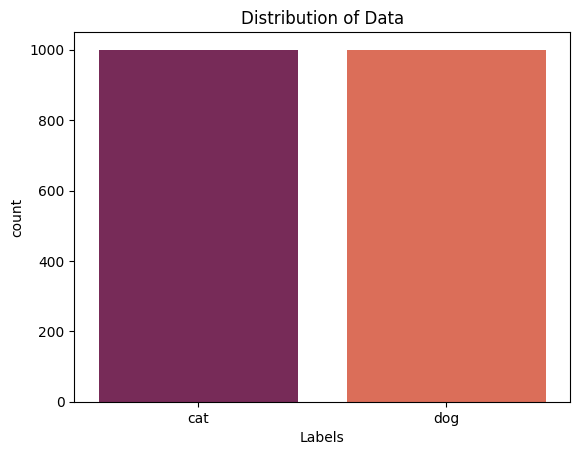

In [6]:
sns.countplot(x=df['Labels'], hue=df['Labels'], palette='rocket')
plt.title('Distribution of Data')
plt.show()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   File_Paths  1999 non-null   object
 1   Labels      1999 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [8]:
df.describe()

,File_Paths,Labels
count,1999,1999
unique,1999,2
top,/content/gdrive/MyDrive/Colab Notebooks/cats_a...,dog
freq,1,1000


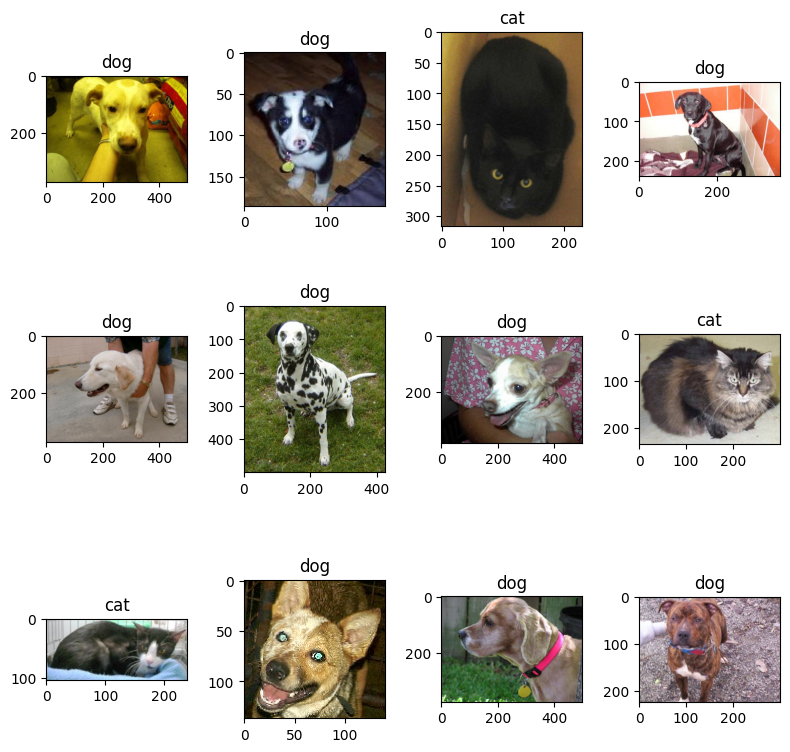

In [9]:
random_idx = np.random.randint(0, len(df), 12)
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(8,8))

for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(df.File_Paths[random_idx[i]]))
  ax.set_title(df['Labels'][random_idx[i]])

plt.tight_layout()
plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['File_Paths'], df['Labels'], test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1599,), (400,), (1599,), (400,))

In [11]:
labelencoder = LabelEncoder()
y_train_encoded = labelencoder.fit_transform(y_train)
y_test_encoded = labelencoder.fit_transform(y_test)

In [12]:
X_train.shape, X_test.shape, y_train_encoded.shape, y_test_encoded.shape

((1599,), (400,), (1599,), (400,))

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

df_train = pd.DataFrame({
    'Filepath': X_train,
    'Label': y_train
})

df_test = pd.DataFrame({
    'Filepath': X_test,
    'Label': y_test
})

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory='train_images',
    x_col='Filepath',
    y_col='Label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory='test_images',
    x_col='Filepath',
    y_col='Label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 1599 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


In [14]:
categories = len(set(df['Labels']))

categories

2

In [15]:
y_train_encoded = to_categorical(y_train_encoded, categories)
y_test_encoded = to_categorical(y_test_encoded, categories)

X_train.shape, X_test.shape, y_train_encoded.shape, y_test_encoded.shape

((1599,), (400,), (1599, 2), (400, 2))

In [16]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(categories, activation='softmax')
])

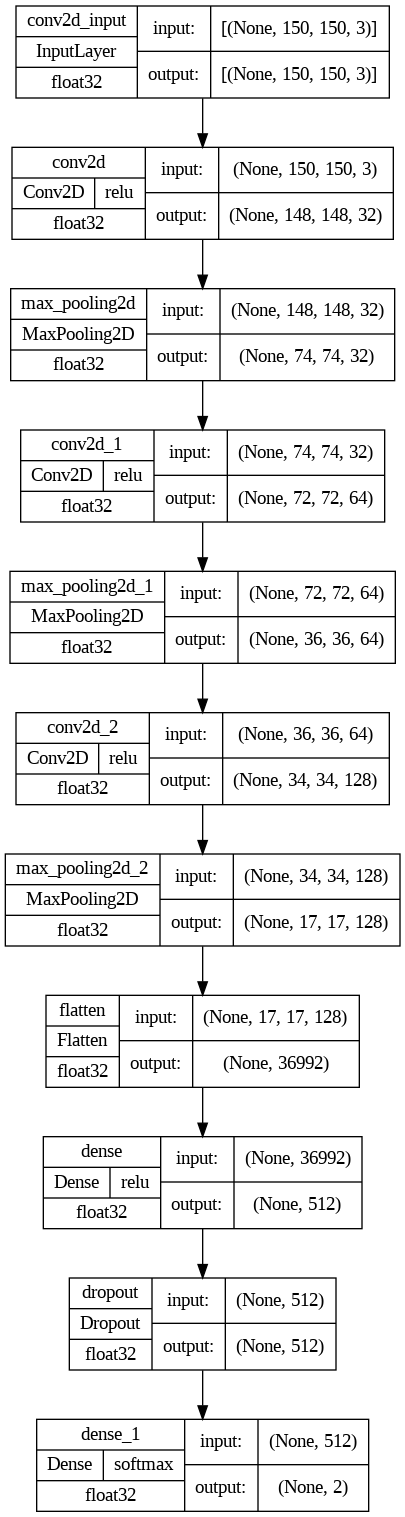

In [17]:
plot_model(model, show_dtype=True, show_shapes=True, show_layer_activations=True, show_layer_names=True)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [19]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
49/49 [==============================] - 111s 2s/step - loss: 0.7629 - accuracy: 0.5010 - val_loss: 0.6896 - val_accuracy: 0.5729
Epoch 2/10
49/49 [==============================] - 108s 2s/step - loss: 0.6815 - accuracy: 0.5431 - val_loss: 0.6669 - val_accuracy: 0.6276
Epoch 3/10
49/49 [==============================] - 100s 2s/step - loss: 0.6493 - accuracy: 0.6190 - val_loss: 0.6462 - val_accuracy: 0.6094
Epoch 4/10
49/49 [==============================] - 105s 2s/step - loss: 0.6012 - accuracy: 0.6962 - val_loss: 0.6736 - val_accuracy: 0.6302
Epoch 5/10
49/49 [==============================] - 105s 2s/step - loss: 0.5693 - accuracy: 0.7237 - val_loss: 0.7491 - val_accuracy: 0.6250
Epoch 6/10
49/49 [==============================] - 105s 2s/step - loss: 0.4897 - accuracy: 0.7620 - val_loss: 0.6107 - val_accuracy: 0.6979
Epoch 7/10
49/49 [==============================] - 105s 2s/step - loss: 0.4202 - accuracy: 0.8073 - val_loss: 0.6912 - val_accuracy: 0.6562
Epoch 8/10
49

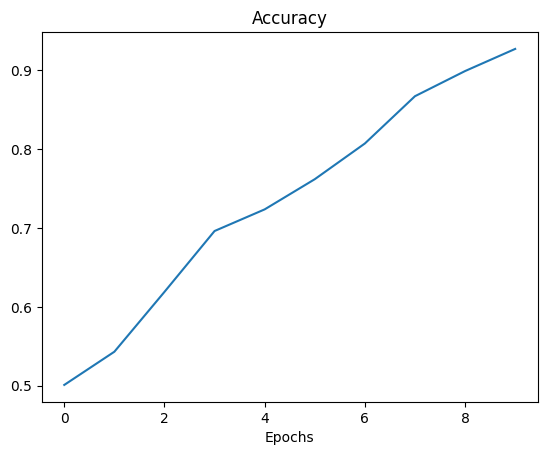

In [21]:
plt.plot(history.history['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')

plt.show()

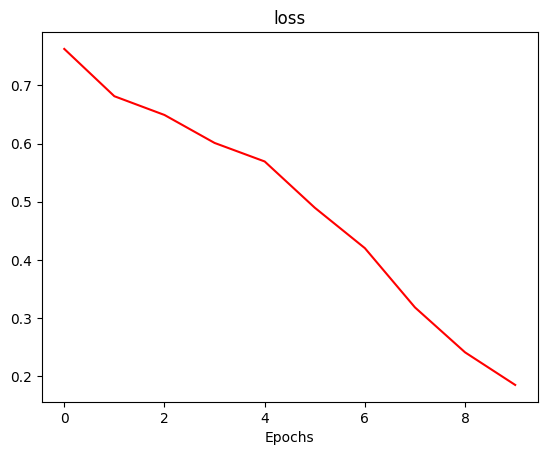

In [22]:
plt.plot(history.history['loss'], c='r')
plt.title('loss')
plt.xlabel('Epochs')

plt.show()

In [23]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Test accuracy: {accuracy} Test Loss: {loss}')

13/13 [==============================] - 7s 500ms/step - loss: 0.9325 - accuracy: 0.6925
Test accuracy: 0.6924999952316284 Test Loss: 0.9325478076934814


In [24]:
def predict_random_image(model, generator, label_encoder):
    batch = next(generator)
    images, labels = batch

    idx = random.randint(0, len(images) - 1)

    plt.imshow(images[idx])
    actual_label = label_encoder.inverse_transform([np.argmax(labels[idx])])[0]
    plt.title(f'Actual: {actual_label}')
    plt.show()

    image = images[idx].reshape(1, 150, 150, 3)
    y_pred = model.predict(image)
    predicted_class = label_encoder.inverse_transform([np.argmax(y_pred)])

    print(f'Prediction probabilities: {y_pred}')
    print(f'Predicted class: {predicted_class[0]}')

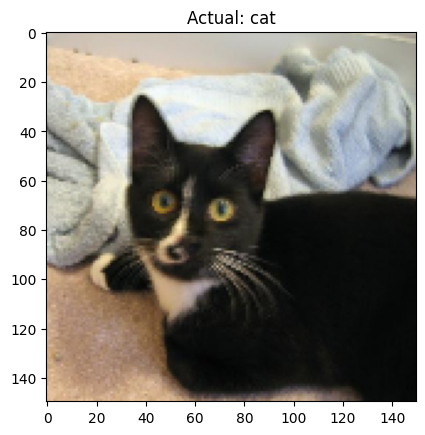

1/1 [==============================] - 0s 246ms/step
Prediction probabilities: [[9.999645e-01 3.553832e-05]]
Predicted class: cat


In [26]:
predict_random_image(model, validation_generator, labelencoder)

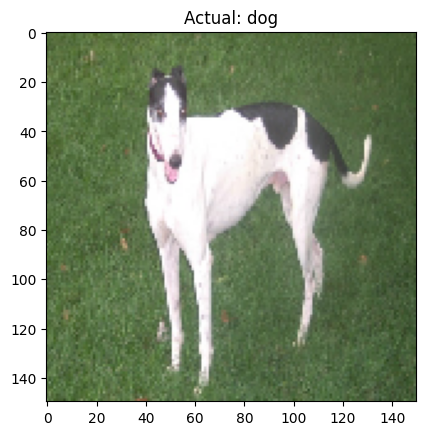

1/1 [==============================] - 0s 39ms/step
Prediction probabilities: [[1.4412221e-12 1.0000000e+00]]
Predicted class: dog


In [31]:
predict_random_image(model, validation_generator, labelencoder)